# Analyzing subway data

## Abstract
In this project, I am analyzing subway data over a 3-month period to identify the top 10 busiest train stations. 

**Note:**
This code is excerpted from my original project "How can we recommend a better train schedule based on the traffic at the stations?". The full code can be found under my [github repo](https://github.com/lee-jin81/metis_project_1_EDA)

**Source of data: http://web.mta.info/developers/turnstile.html**

### Retrieve data 

In [1]:
#import libraries and packages
from sqlalchemy import create_engine
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

In [3]:
# data is stored in SQLite
# query data from SQL database
engine = create_engine('sqlite:///mta_data_project.db')

# load database with pandas
df = pd.read_sql('SELECT * FROM mta_data', engine)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


### Clean data

In [4]:
# create a datetime column 
df['DATE_TIME'] = pd.to_datetime(df['DATE'] + " " + df['TIME'])

# sort data in descending order (last entries first)
df.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'], inplace = True, ascending=False)

In [5]:
# check for duplicates
# Note: each combination of C/A, UNIT, SCP, and STATION represents a unique turnstile 
# Each datetime should only have 1 entry per tunrstile
# grouping data by c/a, unit, scp to represent each station at each date time entry
(df
 .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'])
.ENTRIES.count()
.reset_index()
.sort_values('ENTRIES', ascending=False)
.head(2))

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
405945,G001,R151,00-05-01,CONEY IS-STILLW,2021-11-08,2
2710700,S101,R070,00-00-02,ST. GEORGE,2021-10-02,2


In [6]:
# prevvious aggregate shows that station coney and st.george have 2 entries.
# what causes multiple entries per turnstile per datetime?
# Each datetime should only have 1 entry per tunrstile.
# create a mask to analyze station coney
mask = (df[(df['C/A'] == 'G001') &
          (df['UNIT'] == 'R151') &
          (df['SCP'] == '00-05-01') &
          (df['STATION'] == 'CONEY IS-STILLW') & 
          (df['DATE_TIME'] == '2021-11-08 00:00:00')])
mask

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
1292837,G001,R151,00-05-01,CONEY IS-STILLW,DFNQ,BMT,11/08/2021,00:00:00,REGULAR,327700,29,2021-11-08
1292838,G001,R151,00-05-01,CONEY IS-STILLW,DFNQ,BMT,11/08/2021,00:00:00,RECOVR AUD,0,367,2021-11-08


In [7]:
# Coney station has 2 entries at the same datetime: REGULAR and RECOVER AUD
# drop duplicate row of RECOVER AUD and keep REGULAR
df.drop_duplicates(subset=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'], inplace=True)

In [8]:
# check that duplicate entries are removed
# each row should display 1 entry after aggregation
(df
 .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'])
.ENTRIES.count()
.reset_index()
.sort_values('ENTRIES', ascending=False)
.head(2))

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-09-25 00:00:00,1
1821692,R141,R031,00-03-02,34 ST-PENN STA,2021-12-21 15:00:00,1


In [9]:
# drop the desc column since we don't need it anymore
df = df.drop('DESC', axis = 1, errors= 'ignore')

# create a column for a unique turnstile combination
df['TURNSTILE'] = df['C/A'] + ' ' + df['UNIT'] + ' ' + df['SCP'] + ' ' + df['STATION']

### Calculate daily entries at a subway station

In [10]:
# create a new df with selected columns that we need for analysis.
df2 = df[['TURNSTILE','LINENAME','STATION', 'DATE', 'DATE_TIME', 'ENTRIES']]
df2 = pd.DataFrame(df2)

df2.sort_values(['TURNSTILE','STATION', 'DATE', 'DATE_TIME'], inplace = True, ascending = False)

df2.head(2)

,TURNSTILE,LINENAME,STATION,DATE,DATE_TIME,ENTRIES
210382,TRAM2 R469 00-05-01 RIT-ROOSEVELT,R,RIT-ROOSEVELT,12/24/2021,2021-12-24 20:00:00,5562
210381,TRAM2 R469 00-05-01 RIT-ROOSEVELT,R,RIT-ROOSEVELT,12/24/2021,2021-12-24 16:00:00,5562


In [11]:
# create columns to display the previes datetime for entries data
df2[['PREV_DATE_TIME', 'PREV_ENTRIES']] = \
(df2.groupby(['TURNSTILE','STATION'], as_index = False)\
 [['DATE_TIME','ENTRIES']]\
 .apply(lambda grp: grp.shift(1)))

In [12]:
# drop rows with no previous dates
df2.dropna(subset=['PREV_DATE_TIME'], axis = 0, inplace=True)

#check for null values
df2.isna().sum()
df2.head(1)

,TURNSTILE,LINENAME,STATION,DATE,DATE_TIME,ENTRIES,PREV_DATE_TIME,PREV_ENTRIES
210381,TRAM2 R469 00-05-01 RIT-ROOSEVELT,R,RIT-ROOSEVELT,12/24/2021,2021-12-24 16:00:00,5562,2021-12-24 20:00:00,5562.0


#### Apply counter to entries

Calculate actual entries by applying a function that takes into account that a counter reset number of entries after it reaches a maximum count

In [13]:
# function returns entries data assuming that counter was reset
# max_count: number at which counter resets
def entries_counter(row, max_count):
    # entries data are cumulative 
    # to calculate entries per day, take the difference from the previous day
    count = row['ENTRIES'] - row['PREV_ENTRIES']
    
    # if count is a negative value, assume that counter is in reverse,
    # get a positive value instead
    if count < 0:
        count = -count
    
    # assume counter was reset to 0, choose min value 
    if count > max_count:
        count = min(row['ENTRIES'], row['PREV_ENTRIES'])
    
    # check again if minimum value of entries is still greater than max count
    # return zero if that is the case
    if count > max_count:
        return 0
    
    return count

Reset the counter at 172,800. Assumptions made:
* There are 86,400 seconds per day. 
* Assuming 2 entries per turnstile per second, a single turnstile can have up to 172,800 entries per day. 

In [14]:
# Now we can calculate daily entries from the cumulative data.
# create new columns displaying actual entries per day
df2['DAILY_ENTRIES'] = df2.apply(entries_counter, axis = 1, max_count = 172_800)

### Calculate daily entries by station

In [15]:
# aggregate entries by station by day
station_total_entries = (df2.groupby('STATION', as_index = False)
                         [['DAILY_ENTRIES']].sum()
                         .sort_values('DAILY_ENTRIES', ascending = False)
                         .reset_index())

station_total_entries.head(2)

,index,STATION,DAILY_ENTRIES
0,61,34 ST-PENN STA,4841767.0
1,258,JOURNAL SQUARE,3722143.0


Text(0.5, 1.0, 'Daily entries of the top 10 busiest stations')

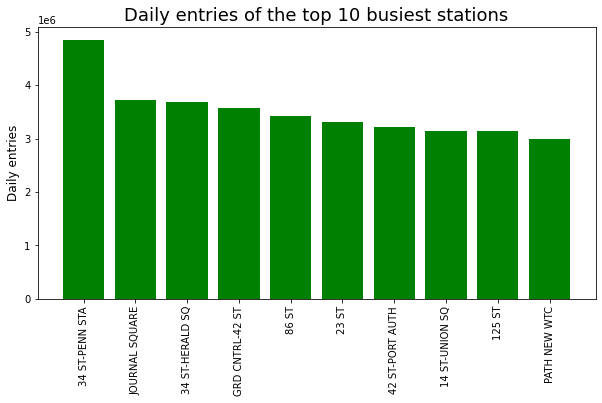

In [16]:
# plot bar chart displaying daily entries of stations. 
plt.figure(figsize=[10,5])

plt.bar(x = station_total_entries['STATION'][:10], height = station_total_entries['DAILY_ENTRIES'][:10], \
        color='green')
plt.xticks(rotation = 90)
plt.ylabel('Daily entries', size=12)
plt.title('Daily entries of the top 10 busiest stations', size=18)

* The busiest station is 34 ST-PENN STA.

In [36]:
# graph hourly entries of 34 ST-PENN STA over the 3-month period
# filter data to include 34 st-penn sta only
penn_station_mask = df2[df2['STATION'] == '34 ST-PENN STA']

# datetime, and daily_entries column only
penn_station_df = penn_station_mask[['DATE_TIME', 'DAILY_ENTRIES']]
penn_station_df.head()

,DATE_TIME,DAILY_ENTRIES
140858,2021-12-24 17:00:00,43.0
140857,2021-12-24 13:00:00,64.0
140856,2021-12-24 09:00:00,66.0
140855,2021-12-24 05:00:00,27.0
140854,2021-12-24 01:00:00,5.0


In [37]:
# function that rounds time to the nearest hour

# time is in the format hh:mm:ss
# round the timestamp to the nearest hour
# return hour as an integer
# e.g. 03:30:00 will return the integer 4
def round_hour(TIME):
    
    # round hour up if it is greater than 30 min else round hour down
    # e.g 03:35:00 will return 04:00:00
    if TIME.minute >= 30:
        timeString = str(TIME.replace(second=0, microsecond=0, minute=0, hour=TIME.hour+1))
    else:
        timeString = str(TIME.replace(second=0, microsecond=0, minute=0))
        
    # only return the hour portion of TIME diplayed as two digits (e.g. 04, 12, and etc)
    # for single digit hour (e.g 04) we will return the second digit (index 1), omitting the zeros
    # e.g 04 will return 4
    # for 2 digits hour (e.g 12) we will return both digits (index 0:2)
    if timeString[0] == '0':
        return int(timeString[1])
    
    else:
        return int(timeString[0:2]) 

In [43]:
# create a column displaying the hour of the day
# apply function round_hour to round hour to the nearest integer 
penn_station_df['HOUR'] = penn_station_df.loc[:,'DATE_TIME'].dt.time.apply(round_hour)
penn_station_df.head()

/var/folders/rb/xjz9rwgx62s435ny2cx4kwk40000gn/T/ipykernel_15783/3643243443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penn_station_df['HOUR'] = penn_station_df.loc[:,'DATE_TIME'].dt.time.apply(round_hour)


,DATE_TIME,DAILY_ENTRIES,HOUR
140858,2021-12-24 17:00:00,43.0,17
140857,2021-12-24 13:00:00,64.0,13
140856,2021-12-24 09:00:00,66.0,9
140855,2021-12-24 05:00:00,27.0,5
140854,2021-12-24 01:00:00,5.0,1


In [26]:
# aggregate daily_entries for every hour
penn_station_hourly = penn_station_df.groupby('HOUR')['DAILY_ENTRIES'].sum()
penn_station_hourly.head()

HOUR
0     33701.0
1      9206.0
2     15185.0
3    102710.0
4    217018.0
Name: DAILY_ENTRIES, dtype: float64

Text(0.5, 0, 'Time (24-hour)')

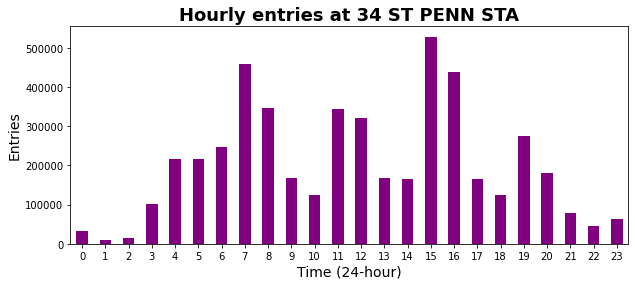

In [27]:
# bar plot showing daily entries at each hour
plt.figure(figsize=[10,4])
penn_station_hourly.plot.bar(color='purple')

plt.title('Hourly entries at 34 ST PENN STA', size=18, weight='bold')
plt.ylabel('Entries', size=14)
plt.xticks(rotation=0)
plt.xlabel('Time (24-hour)', size =14)